# Ensemble Learning for different classifiers
We apply ensemble learning on the iris dataset (available on sklearn). 
We first train several classifier using piplenes and gridsearch. We then compare it with a majority voting classifier that groups all classifiers together.
We also introduce bagging and compare it with a single decision tree model
We finally introduce Adaboost and compare results with a single leraner classifier

## Training classifiers using pipelines and gridsearch
We train a Logistic Regression, Decision tree and K-neighboring classifiers using gridsearch and pipelines to obtain the optimal roc and accuracy for each classifier

In [14]:
import math
import numpy as np 
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
import pandas as pd 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier



               
#begin
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
###

X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.5,random_state=1,stratify=y)

#LR,DT,KN make pipes
pipe_lr=make_pipeline(StandardScaler(),LogisticRegression(random_state=1,n_jobs=-1,C=0.001,solver='lbfgs'))
pipe_lr.fit(X_train,y_train)
pipe_DT=make_pipeline(StandardScaler(),DecisionTreeClassifier(criterion='entropy',max_depth=1,random_state=0))
pipe_DT.fit(X_train,y_train)
pipe_KN=make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=1,n_jobs=-1))
pipe_KN.fit(X_train,y_train)
#setup params for gridsearch
param_lr={'logisticregression__C':[0.001,0.01,0.1,1,10,100]}
param_DT={'decisiontreeclassifier__criterion':['entropy','gini'],'decisiontreeclassifier__max_depth':[1,2,3,None]}
param_KN={'kneighborsclassifier__n_neighbors':[1,2,3,4,5],'kneighborsclassifier__p':[1,2]}

#group things together in prep for a gridsearch for loop
params=[param_lr,param_DT,param_KN]
pipes=[pipe_lr,pipe_DT,pipe_KN]
clf_lables=['lr','DT','KN']
best_es=[]
for lb,pip,par in zip(clf_lables,pipes,params):
    cv=GridSearchCV(pip,par,scoring='roc_auc',cv=10,n_jobs=-1, iid='deprecated')
    cv.fit(X_train,y_train)
    print('best params for %s :' % lb)
    print(cv.best_params_)
    print("this gives a best score for %s of %.3f +/- %.3f" % (lb,cv.best_score_,cv.cv_results_['std_test_score'][cv.best_index_]))
    y_predico=cv.best_estimator_.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_predico)
    print("%s used on unseen data gives the score of %.3f :\n\n" %(lb,auc(fpr,tpr)))
    best_es.append((lb,cv.best_estimator_))








best params for lr :
{'logisticregression__C': 1}
this gives a best score for lr of 0.973 +/- 0.072
lr used on unseen data gives the score of 0.940 :


best params for DT :
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 2}
this gives a best score for DT of 0.943 +/- 0.127
DT used on unseen data gives the score of 0.900 :


best params for KN :
{'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 2}
this gives a best score for KN of 0.967 +/- 0.072
KN used on unseen data gives the score of 0.920 :




## Constructing a majority voting classifier and compare it with previous models

We now combine all previous models into one majority voting learner and compare accuracy
We also plot Decision regions for each classifier

roc score for maj_voting is 0.978 +/- 0.067
roc score for unseen data for maj vote is 0.940


acc score for maj_voting is 0.908 +/- 0.160
acc score for unseen data for maj vote is 0.920


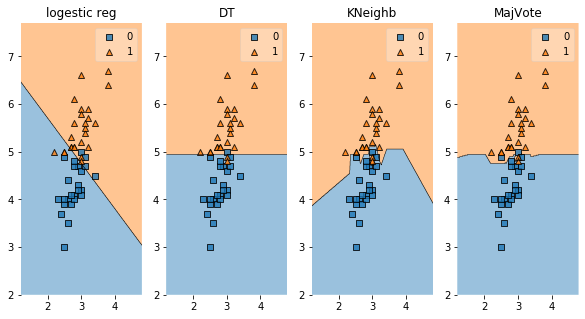

In [9]:
# roc scoring using maj vote
vc=VotingClassifier(estimators=best_es,voting='soft',weights=[1,1,1],n_jobs=-1)
score1=cross_val_score(vc,X_train,y_train,scoring='roc_auc',cv=10)
vc.fit(X_train,y_train)
y_pred1=vc.predict(X_test)
print("roc score for maj_voting is %.3f +/- %.3f" % (score1.mean(),score1.std()))
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred1)
print("roc score for unseen data for maj vote is %.3f\n\n" % (auc(fpr1,tpr1)))

#trying accuracy for hard vote
vc1=VotingClassifier(estimators=best_es,voting='hard',weights=[1,2,3],n_jobs=-1)
score_acc=cross_val_score(vc1,X_train,y_train,scoring='accuracy',cv=10)
vc1.fit(X_train,y_train)
#y_pred2=vc1.predict(X_test)
print("acc score for maj_voting is %.3f +/- %.3f" % (score_acc.mean(),score_acc.std()))
print("acc score for unseen data for maj vote is %.3f" % vc1.score(X_test,y_test))

#trying to plot decision regions 

plt.figure(figsize=(10, 5))
plt.subplot(141)
plot_decision_regions(X_train,y_train,clf=pipe_lr)
plt.title('logestic reg')
plt.subplot(142)
plot_decision_regions(X_train,y_train,clf=pipe_DT)
plt.title('DT')
plt.subplot(143)
plot_decision_regions(X_train,y_train,clf=pipe_KN)
plt.title('KNeighb')
plt.subplot(144)
plot_decision_regions(X_train,y_train,clf=vc)
plt.title('MajVote')
plt.show()

#moving on to bagging: a techinique used for ensemble learning to avoid fitting the same data for each individual clf
#import wine and make it highly unprerdictible: drop a class and most of the features
import pandas as pd
df_wine = pd.read_csv('C:\\Users\\marwe\\Downloads\\wine.data',header=None)
df_wine.columns = ['Class label', 'Alcohol','Malic acid', 'Ash','Alcalinity of ash','Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']
df_wine=df_wine[df_wine['Class label'] != 1]
y_wine = df_wine['Class label'].values
X_wine = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values
lb1=LabelEncoder()
y_wine=lb1.fit_transform(y_wine)
X_wtrain,X_wtest,y_wtrain,y_wtest = train_test_split(X_wine,y_wine,test_size=0.2,random_state=1, stratify=y_wine)




## Bagging vs single tree 

We compare results between a Bagging model (500 trees) and a single tree classifier
We also plot our decision region for each classifier

accuracy score for a single tree train/test is 1.000/0.833


accuracy score for the bagging train/test is 1.000/0.917




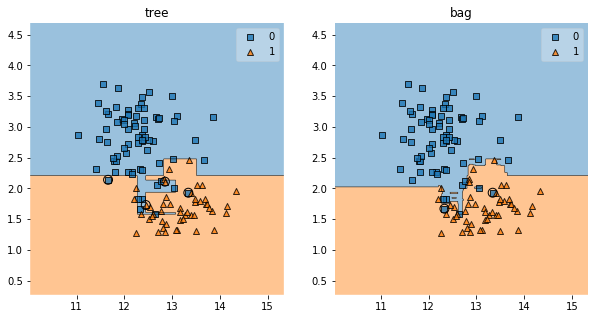

In [12]:
#after reading and preprocessing, we do bagging on 500 unpruned trees
tree=DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=None)
bag = BaggingClassifier(base_estimator=tree,n_estimators=500,max_samples=1.0,max_features=1.0,bootstrap=True,bootstrap_features=False,n_jobs=1,random_state=1)
#comparing a single true fitted to the entire train and test to bagging technique
#tree
tree=tree.fit(X_wtrain,y_wtrain)
y_train_pred=tree.predict(X_wtrain)
y_test_pred=tree.predict(X_wtest)
print("accuracy score for a single tree train/test is %.3f/%.3f\n\n" % (accuracy_score(y_wtrain,y_train_pred),accuracy_score(y_wtest,y_test_pred)))

#bagging
bag=bag.fit(X_wtrain,y_wtrain)
y_train_pred1=bag.predict(X_wtrain)
y_test_pred1=bag.predict(X_wtest)
print("accuracy score for the bagging train/test is %.3f/%.3f\n\n" % (accuracy_score(y_wtrain,y_train_pred1),accuracy_score(y_wtest,y_test_pred1)))

#slight difference in favor of bagging, next plot decision region
X_reg=np.vstack((X_wtrain,X_wtest))
Y_reg=np.hstack((y_wtrain,y_wtest))
#plotting dec regions
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_decision_regions(X_reg,Y_reg,clf=tree,X_highlight=X_wtest[y_wtest!=y_test_pred])
plt.title('tree')
plt.subplot(122)
plot_decision_regions(X_reg,Y_reg,clf=bag,X_highlight=X_wtest[y_wtest!=y_test_pred1])
plt.title('bag')
plt.show()

## Adaboost vs Decision Tree
We compare results between an Adaboost model and a single tree classifier
We also plot our decision region for each classifier

score for a single weak DT for train/test: 0.916/0.875


score for adaboost for train/test: 1.000/0.917




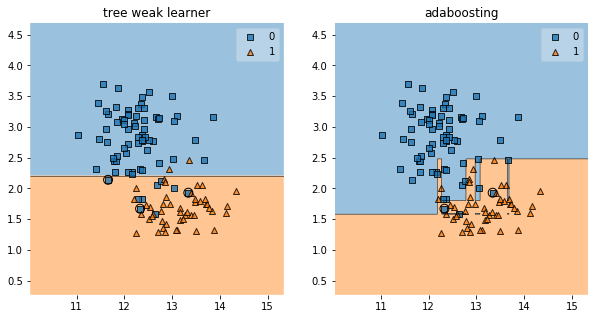

In [13]:

#now we use adaboost to train weak learners and learn from mistakes and compare it to a single weak learner
#we use the previously used tree but we will name it tree1 just to avoid confusion
tree1=DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=1)
tree1=tree1.fit(X_wtrain,y_wtrain)
y_pre_train=tree1.predict(X_wtrain)
y_pre_test=tree1.predict(X_wtest)
#score for weak learner
print('score for a single weak DT for train/test: %.3f/%.3f\n\n' %(accuracy_score(y_wtrain,y_pre_train),accuracy_score(y_wtest,y_pre_test)))
#teym for adaboost
ada=AdaBoostClassifier(base_estimator=tree1,n_estimators=500,learning_rate=0.1,random_state=1)
ada=ada.fit(X_wtrain,y_wtrain)
y_pre_traina=ada.predict(X_wtrain)
y_pre_testa=ada.predict(X_wtest)
print('score for adaboost for train/test: %.3f/%.3f\n\n' %(accuracy_score(y_wtrain,y_pre_traina),accuracy_score(y_wtest,y_pre_testa)))
#ada boost performs better with both training and testing, it shows that we were successfully able to reduce bias
#however more learners means higher variande (more overfitting expressed by higher train/test gap)
#ada reduces bias but introduces more variance 


#last thing, decision regions!!!
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_decision_regions(X_reg,Y_reg,clf=tree1,X_highlight=X_wtest[y_wtest!=y_pre_test])
plt.title('tree weak learner')
plt.subplot(122)
plot_decision_regions(X_reg,Y_reg,clf=ada,X_highlight=X_wtest[y_wtest!=y_pre_testa])
plt.title('adaboosting')
plt.show()
